In [59]:
import pandas as pd

# Dataset location

datasetFolder="datasets/"
datasetFiles = {
    "Agricultural Land"                :"agriculturalLand.csv",
    "Debt"                             :"centralGovernmentDebt.csv",
    "CO2 Emissions"                    :"CO2Emissions.csv",
    "Account Balance"                  :"currentAccountBalance.csv",
    "Electric Consumption"             :"electricPowerConsumption.csv",
    "Energy Imports"                   :"energyImports.csv",
    "Energy Use"                       :"energyUse.csv",
    "Forest Area"                      :"forestArea.csv",
    "Fuel Exports"                     :"fuelExports.csv",
    "GDP"                              :"GDP.csv",
    "GDP Procapite"                    :"GDPProCapite.csv",
    "Life expectancy"                  :"lifeExpectancy.csv",
    "Population"                       :"Population.csv",
    "Renewable Electricity Consumption":"renewableElectricityConsumption.csv",
    "Renewable Electricity Output"     :"renewableElectricityOutput.csv",
    "Money Reserves"                   :"TotalReserves.csv"
}

# Entries to be excluded

ex = [
        #"China",
        #"United States",
        "World",
        "Arab World",
        "Central Europe and the Baltics",
        "Caribbean small states",
        "East Asia & Pacific (excluding high income)",
        "Early-demographic dividend",
        "East Asia & Pacific",
        "Europe & Central Asia (excluding high income)",
        "Europe & Central Asia",
        "Euro area",
        "European Union",
        "High income",
        "Heavily indebted poor countries (HIPC)",
        "IBRD only",
        "IDA & IBRD total",
        "IDA total",
        "IDA blend",
        "IDA only",
        "Not classified",
        "Latin America & Caribbean (excluding high income)",
        "Latin America & Caribbean",
        "Least developed countries: UN classification",
        "Low income",
        "Lower middle income",
        "Low & middle income",
        "Late-demographic dividend",
        "Middle East & North Africa",
        "Middle income",
        "Middle East & North Africa (excluding high income)",
        "North America",
        "OECD members",
        "Other small states",
        "Pre-demographic dividend",
        "Pacific island small states",
        "Post-demographic dividend",
        "Sub-Saharan Africa (excluding high income)",
        "Sub-Saharan Africa",
        "Sub-Saharan Africa (IDA & IBRD countries)"
        "Small states",
        "East Asia & Pacific (IDA & IBRD countries)",
        "Europe & Central Asia (IDA & IBRD countries)",
        "Latin America & the Caribbean (IDA & IBRD countries)",
        "Middle East & North Africa (IDA & IBRD countries)",
        "South Asia (IDA & IBRD)",
        "Upper middle income",
        "World",
        "Fragile and conflict affected situations",
        "South Asia",
        "Sub-Saharan Africa (IDA & IBRD countries)"
]

# Years of interest

interestInterval = (1990, 2016)
startingYear = 1960

# Dataframe building

dfList = []
for key, value in datasetFiles.items(): 
    tempDfList = []
    dataframe = pd.read_csv(datasetFolder+value, sep=',', header=2)
    
    # Each file considered starts from 1960. Each value equal to NaN for that year
    # is put to 0. Each following NaN for that dataset will take the closest previous
    # value different from NaN.
    # e.g.: NaN NaN NaN 1 2 3 NaN NaN 4
    # Supposing that the first NaN refers to 1960,
    # this row will turn first in:  0 NaN NaN 1 2 3 NaN NaN 4
    # and then to: 0 0 0 1 2 3 3 3 4
    dataframe[str(startingYear)].fillna(0, inplace=True)
    dataframe = dataframe.fillna(method='ffill', axis=1)
    
    # For each file is created a new dataframe in which each row
    # is composed by Country Name, Value of interest of dataset (e.g. GDP), Year of that value
    # so each country appears once for each year of interest (in this case 27 times)
    for i in range (interestInterval[0], interestInterval[1]+1):
        temp_df = dataframe[["Country Name",str(i)]]
        temp_df.is_copy = False
        temp_df['Year'] = i
        # Renaming for Country Name and adding of column Year
        temp_df.columns=["Country", key, "Year"]
        tempDfList.append(temp_df)    
    # Each element of the dfList refers to a single "new" dataset.
    # Those datasets must be merged by column
    dfList.append(pd.concat(tempDfList))
    

# Merging of datasets by columns "Country" and "Year"
df = dfList[0]
for i in range(1, len(dfList)):
    df = pd.merge(df, dfList[i], on=["Country","Year"])
    

# Columns rearrangement to have Year and Country Name as first columns
cols = df.columns.tolist()
year_i = cols.index("Year")
cols.pop(year_i)
cols = ["Year"] + cols
df = df[cols]

# Conversion, when possible, to numeric values (instead of string)
df = df.apply(pd.to_numeric, errors='ignore')

# Filtering out
df = df[~df['Country'].isin(ex)]
df.dtypes

Year                                   int64
Country                               object
Agricultural Land                    float64
Debt                                 float64
CO2 Emissions                        float64
Account Balance                      float64
Electric Consumption                 float64
Energy Imports                       float64
Energy Use                           float64
Forest Area                          float64
Fuel Exports                         float64
GDP                                  float64
GDP Procapite                        float64
Life expectancy                      float64
Population                           float64
Renewable Electricity Consumption    float64
Renewable Electricity Output         float64
Money Reserves                       float64
dtype: object

# Supervised Learning

## Linear Regression

In [60]:
import numpy as np
from numpy.linalg import inv

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# LINEAR REGRESSION

country = "Italy"
target_df = df.loc[df['Country']==country]

# Excluding country name
target_df = target_df.drop(df.columns[[1]], axis=1)



class LinearRegression:
    def __init__(self):
        self.beta = None
    
    def train(self, X, y):
        X = self._x_format(X)     
        # beta = (X^T * X)^(-1) * X^T * y
        self.beta = np.dot(np.dot(inv(np.dot(X.T, X)), X.T), y)
    
    def predict(self, X_input):
        x_input = self._x_format(X_input)
        # result = x_input * beta
        return np.dot(x_input, self.beta)
    
    def _x_format(self, X):
        X = np.c_[ np.ones(X.shape[0]), X]
        return X

def dataPreprocessing(df):  
    # Ignoring year column
    df = df.drop(df.columns[[0]], axis=1)
    # Scaling
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns.values)
    
    # x_input will be the first input of our linear regression
    x_input = pd.DataFrame(df.iloc[-1])
    
    y = df.iloc[1:]
    X = df.iloc[:df.shape[0]-1]

    # data formatting as matrix
    x_input = x_input.as_matrix().T
    y = y.as_matrix()
    X = X.as_matrix()
    
    return X,y,x_input,scaler

# Prediction trial for 10 years
pred_years = 10
for i in range(1, pred_years+1):
    X,y,x_input,scal = dataPreprocessing(target_df)
    LR = LinearRegression()
    LR.train(X,y)
    # LR's beta in this case has dimension 17x16: 
    # 17 is the number of input variable (1 for bias)
    # 16 is the number of output variable
    y_hat = scal.inverse_transform(LR.predict(x_input))
    
    # Rebuilding of DataFrame, reinserting the Year at the end
    columns = list(df.columns)
    columns.remove("Country")
    columns.remove("Year")
    result = pd.DataFrame(data=y_hat)
    result.columns = columns
    result.insert(loc=0, column="Year", value=interestInterval[1]+i)

    target_df = pd.concat([target_df, result])
    
target_df.set_index('Year', inplace=True)
target_df

,Agricultural Land,Debt,CO2 Emissions,Account Balance,Electric Consumption,Energy Imports,Energy Use,Forest Area,Fuel Exports,GDP,GDP Procapite,Life expectancy,Population,Renewable Electricity Consumption,Renewable Electricity Output,Money Reserves
Year,,,,,,,,,,,,,,,,
1990,57.257489,0.000000,417550.289000,-1.643777e+10,4144.907442,82.727968,2583.888077,75900.000000,2.289327,1.177326e+12,20757.088678,76.970732,5.671924e+07,3.781463,16.376022,8.859544e+10
1991,54.585019,71.659463,423894.199000,-2.430156e+10,4224.740106,82.634121,2645.673237,76679.000000,2.304151,1.242109e+12,21884.104371,77.019512,5.675852e+07,4.669413,20.846513,7.225431e+10
1992,54.326612,77.720025,420535.227000,-2.927916e+10,4310.537968,81.736186,2627.340008,77458.000000,2.211071,1.315807e+12,23166.804063,77.419512,5.679709e+07,4.839463,20.553919,4.986159e+10
1993,54.095406,77.720025,411917.777000,7.732703e+09,4303.645312,80.938751,2611.990438,78237.000000,2.174555,1.061445e+12,18676.952579,77.721951,5.683182e+07,4.771495,20.579763,5.358981e+10
1994,53.388188,77.720025,407378.031000,1.319967e+10,4439.319253,79.870484,2578.465978,79016.000000,1.593084,1.095591e+12,19273.844170,77.921951,5.684340e+07,5.248022,21.089447,5.781713e+10
1995,52.133555,77.720025,430483.798000,2.509613e+10,4597.892598,81.512308,2799.375762,79795.000000,1.262211,1.170787e+12,20596.388576,78.170732,5.684430e+07,4.462278,17.466002,6.069011e+10
1996,52.187957,77.720025,425830.375000,3.997360e+10,4658.700157,80.960961,2796.154736,80574.000000,1.237706,1.308929e+12,23020.099940,78.521951,5.686028e+07,4.748914,19.308014,7.056644e+10
1997,52.174357,77.720025,430487.465000,3.227669e+10,4791.285246,81.145993,2834.402946,81353.000000,1.434947,1.239051e+12,21779.624367,78.824390,5.689037e+07,4.831420,18.743003,7.508649e+10
1998,52.646969,77.720025,440153.677000,2.010713e+10,4955.721944,81.728602,2912.947365,82132.000000,1.111574,1.266309e+12,22252.358086,78.975610,5.690674e+07,4.757625,18.322525,5.387970e+10


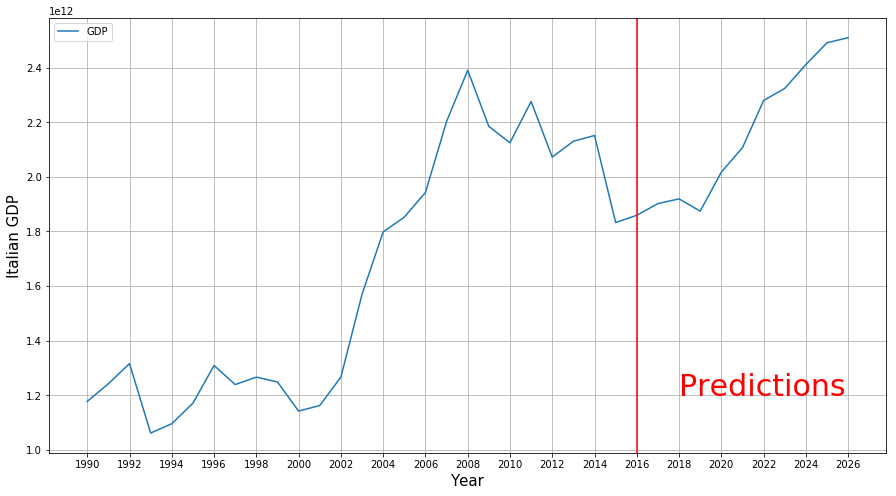

In [61]:
# Var prediction plot example

import matplotlib.pyplot as plt
tar_var = "GDP" 

single_var_df = target_df[[tar_var]]

single_var_df.plot(x=target_df.index, y=tar_var, style='-', figsize=(15,8))
plt.xticks(np.arange(min(target_df.index), max(target_df.index)+1, 2.0))
plt.grid()
plt.ylabel("Italian " + tar_var, fontsize = 15)
plt.xlabel("Year", fontsize = 15)

# We have data until 2016

xcoord = interestInterval[1]
plt.axvline(x=xcoord, color="red")

plt.text(2018, 1.2*(10**12), "Predictions", color="red", fontsize=30)

plt.show()


# Unsupervised Learning

## K-Means Clustering

### Principal Component Analysis

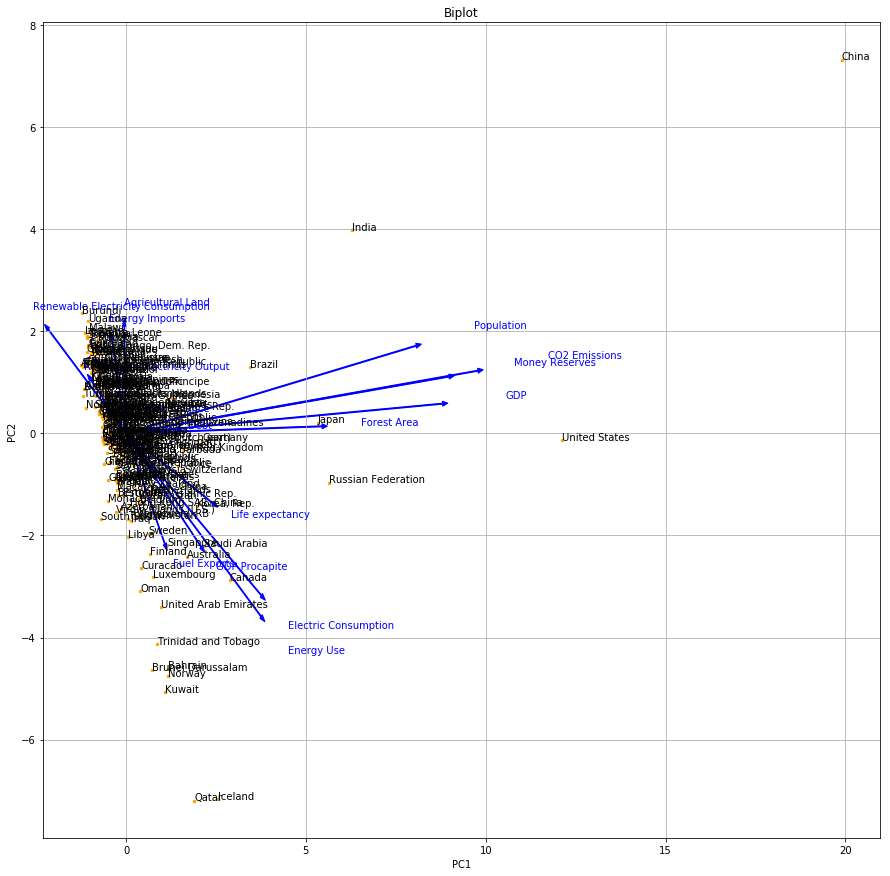

In [62]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

interest_year = 2016
target_df = df.loc[df['Year']==interest_year]

target_df.set_index('Country', inplace=True)

# Excluding year column
target_df = target_df.drop(df.columns[[0]], axis=1)

# Scaling
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(target_df), columns=target_df.columns.values, index=target_df.index)

# Number of components (in biplot I will choose just the principal 2 components)
# I choose 14 to make 
n = target_df.shape[1] 

# Initialization
pca = decomposition.PCA(n_components = n)
pca.fit(scaled_df)

# We take just two components
xvector = pca.components_[0]
yvector = pca.components_[1]

# Projection on the new space
data_transformed = pca.transform(scaled_df)
data_transformed = pd.DataFrame(data_transformed, index=scaled_df.index)

# I take just two columns (two components)
# xs and ys are the projection on the two PCs
xs = data_transformed.iloc[:,0]
ys = data_transformed.iloc[:,1]

## Plot
# Points plotting
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Biplot")
ax.scatter(xs, ys, s=6, c="orange")

# Vector plotting
for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='b', width=0.02, head_width=0.1)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(target_df.columns.values)[i], color='b')

# Annotation plotting
index = list(pd.DataFrame(data_transformed, index=target_df.index).index)
for i, txt in enumerate(index):
    ax.annotate(txt, (xs[i],ys[i]))

plt.grid()
plt.show()



### Explained Variance

Explained variance ratio: 38.0532%


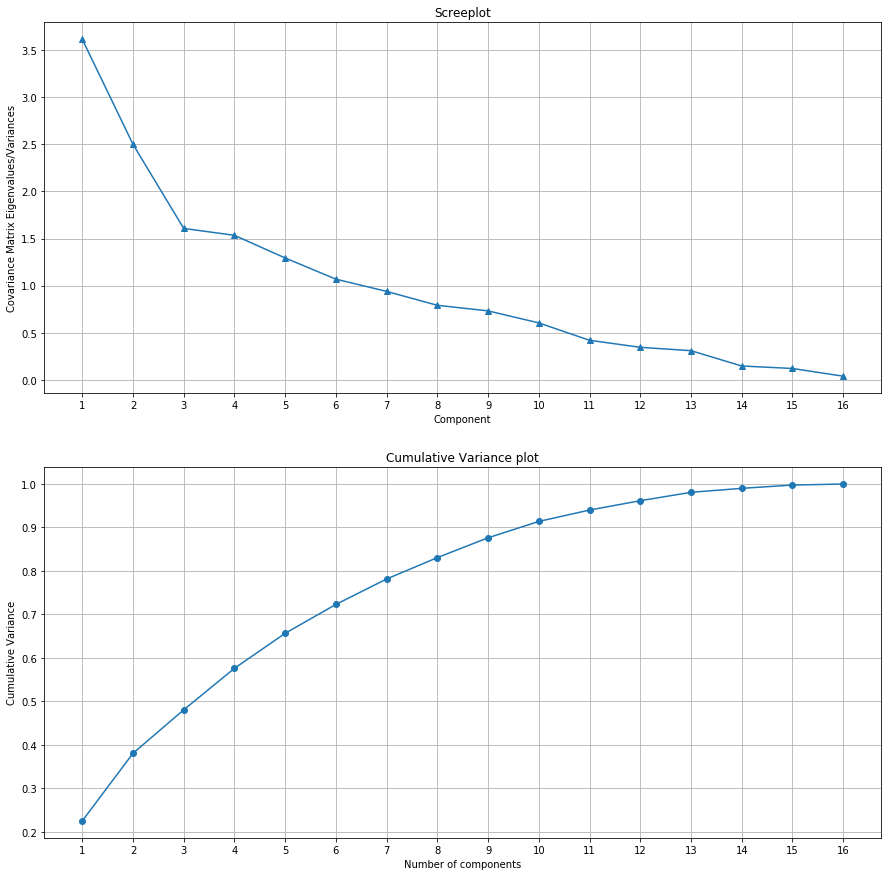

In [63]:
plt.rcParams['figure.figsize'] = (15,15)

# Variance explained:

# Number of component of biplot
n_examined = 2

# Variance for each column
variances = pca.explained_variance_

# Cumulative variance ratio
cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

# Screeplot
plt.subplot(2, 1, 1)
plt.title("Screeplot")
plt.ylabel('Covariance Matrix Eigenvalues/Variances')
plt.xlabel('Component')
plt.plot(pd.Series(variances, index=range(1,n+1)), marker="^", linestyle="-")
plt.xticks(np.arange(1, n+1, 1.0))
plt.grid()

# Cumulative Variance Plot
plt.subplot(2, 1, 2)
plt.title("Cumulative Variance plot")
plt.ylabel('Cumulative Variance')
plt.xlabel('Number of components')
plt.plot(pd.Series(cumulative_variance_ratios, index=range(1,n+1)), marker="o", linestyle="-")
plt.xticks(np.arange(1, n+1, 1.0))
plt.grid()

explained_variance_ratio = sum(pca.explained_variance_ratio_[0:n_examined])
print("Explained variance ratio: {:1.4f}%".format(explained_variance_ratio*100))

### K-Means Clustering

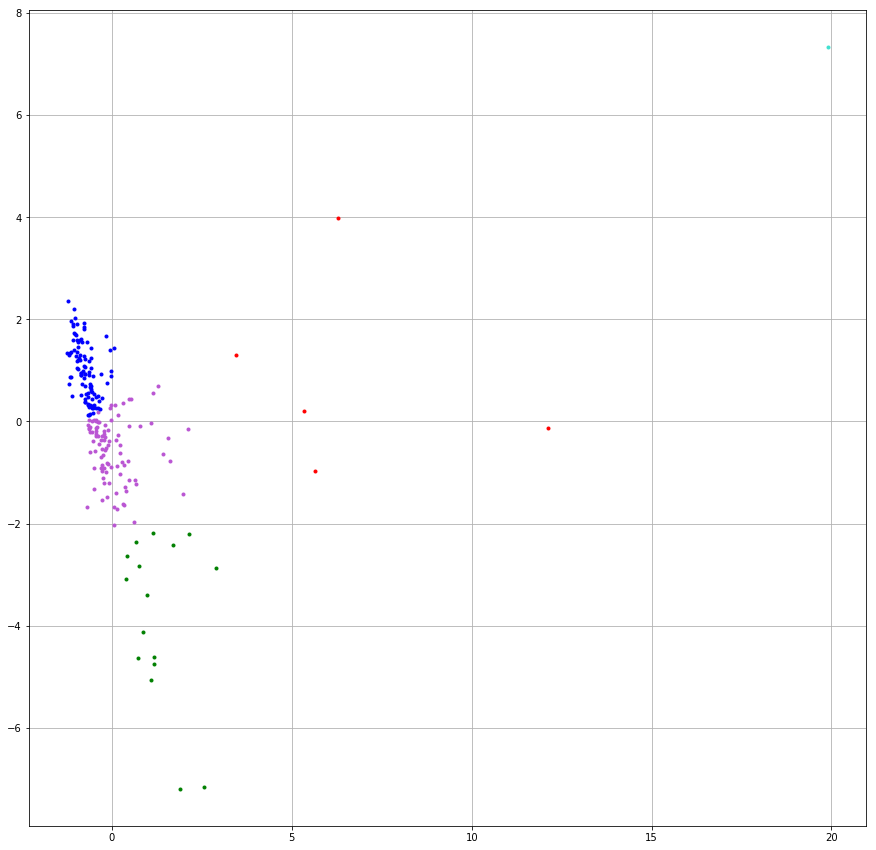

Best silhouette is for K = 5
The best silhouette values (for K = 5) is: 0.4613472982651263


In [82]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Libraries for plot colors
from random import shuffle
import matplotlib._color_data as mcd

# First 2 Principal components DataFrame
PCA2 = data_transformed.iloc[:,0:2]

# Best silhouette and clustering initialization
best_silhouette = 0
best_clustering = None

# Random state
seed = 1

# Clustering several times to search for the best silhouette
for n_cluster in range(2,15):
    
    # random_state is the seed to have always the same starting points
    kmeans = KMeans(n_clusters=n_cluster, random_state=seed).fit(PCA2)
    cluster_labels = kmeans.predict(PCA2)
    
    # Silhouette avg computing (Silhouette of the clustering)
    silhouette_avg = silhouette_score(PCA2, cluster_labels)
    # If I found a better silhouette, I change the previous one 
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_clustering = cluster_labels
    
# The best number of cluster is the highest (numeric) label + 1 (since the labels start from 0)
best_n_clusters = max(best_clustering)+1

# Points plotting
basic_colors = ["Blue","Green","Red"]
all_colors = [name for name in mcd.CSS4_COLORS]
shuffle(all_colors)
colors = basic_colors + [item for item in all_colors if item not in basic_colors]

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo', c=colors[best_clustering[i]], markersize=3)

plt.grid()
plt.show()
print("Best silhouette is for K = "+ str(best_n_clusters))
print("The best silhouette values (for K = " + str(best_n_clusters)+") is: "+str(best_silhouette))


In [74]:
# Printing of cluster colors for each country

cluster_column_name = "Cluster"
clusters = pd.DataFrame(best_clustering, index = target_df.index, columns = [cluster_column_name])
clusters = clusters.sort_values(by=cluster_column_name)
colors_dict = dict(zip(list(range(len(colors))),colors))
clusters[cluster_column_name] = clusters[cluster_column_name].map(colors_dict)
clusters

,Cluster
Country,
Aruba,Blue
Myanmar,Blue
Montenegro,Blue
Mongolia,Blue
Northern Mariana Islands,Blue
Mozambique,Blue
Mauritania,Blue
Mauritius,Blue
Malawi,Blue
